In [1]:
import pandas as pd
import numpy as np
import mysql.connector as mariadb
from astropy.time import Time
%matplotlib notebook
import matplotlib.pyplot as plt
from astropy.table import Table
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option('display.max_columns',100)
pd.set_option('float_format', '{:f}'.format)


from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import Column
from astropy.table import join


In [2]:
import pyspark.sql.functions as sparkfunc
from pyspark.sql import SparkSession

spark_session = (SparkSession.builder
         .config('spark.master', "local[20]")
         .config('spark.driver.memory', '20G')
         .enableHiveSupport()
         .getOrCreate())

In [3]:
import axs
axs_catalog = axs.AxsCatalog(spark_session)

In [9]:
axs_catalog.list_table_names()

['sdss_zoned1am_hd',
 'gaia_zoned1am_hd',
 'gaia_dr2_1am_dup',
 'sdss_zoned1am_700lc',
 'gaia_dr2_700lc2',
 'allwise_1am_dup',
 'gaia_sdss_wise_1asec',
 'gaia_sdss_3asec',
 'ztf_1am_old',
 'ztf_exposures',
 'ztf_1am_lc',
 'ztf_1am',
 'ztf_1am_test',
 'sesar_rrlyrae',
 'ztf_fid1_sdss_stars_lt20_2asec',
 'ztf_fid2_sdss_stars_lt20_2asec',
 'ztf_fid3_sdss_stars_lt20_2asec',
 'sdss_dr9_qso_s82',
 'faraway_training_dataset',
 'faraway_labeled_training_dataset',
 'ztf_nobs100',
 'jnk_ztf_test',
 'jnk_ztf_test2',
 'ztf1000',
 'ztf10',
 'ztf_dec18',
 'asassn_variability_catalog',
 'ztf10_assasn',
 'ztf10_assasn_cesium',
 'ztf10_assasn_best',
 'ztf10_assasn_cesium_best',
 'unwise_v1',
 'cklein_flare',
 'unwise_v2',
 'cesium_speedtest_ztfsample',
 'paula_listcvs',
 'dambis_rrlyrae_metalicity',
 'sdss_500b_28e_10800z',
 'gaia_500b_28e_10800z',
 'allwise_500b_28e_10800z',
 'ztf_500b_28e_10800z',
 'ztf_mar19_all',
 'ztf_dr1_s82_qso',
 'green19_stellar_params',
 'catalina_variables_n',
 'caltech_rosa

In [10]:
axs_catalog.table_info('gaia_dr2_1am_dup')

{'table_id': 47,
 'table_name': 'gaia_dr2_1am_dup',
 'num_buckets': 500,
 'zone_height': 0.0166666666,
 'bucket_col': 'zone',
 'ra_col': 'ra',
 'dec_col': 'dec',
 'has_lightcurves': False,
 'lc_columns': None}

In [11]:
gaia = axs_catalog.load("gaia_dr2_1am_dup")

In [22]:
gaia.columns\

['solution_id',
 'designation',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'astrometric_weight_al',
 'astrometric_pseudo_colour',
 'astrometric_pseudo_colour_error',
 'mean_varpi_factor_al',
 'astrometric_matched_observations',
 'visibility_periods_used',
 'astrometric_sigma5d_max',
 'frame_rotator_object_type',
 'matched_observations',
 'duplicated_source',
 'phot_g_n_ob

In [27]:
%%time
r1 = gaia.region(ra1=0, ra2=0.4, dec1=-0.4, dec2=0.4).select("ra", "dec","phot_g_mean_mag","phot_variable_flag",
                       "designation",  "phot_g_n_obs","dup").toPandas()

r2 = gaia.region(ra1=359.6, ra2=360, dec1=-0.4, dec2=0.4).select("ra", "dec","phot_g_mean_mag","phot_variable_flag",
                       "designation",  "phot_g_n_obs","dup").toPandas()

CPU times: user 82.2 ms, sys: 16.7 ms, total: 98.8 ms
Wall time: 9.68 s


In [31]:
r2['ra_'] = r2['ra']-360

In [32]:
r2['ra_']

0      -0.399329
1      -0.391624
2      -0.386195
3      -0.376580
4      -0.348201
          ...   
1066   -0.082269
1067   -0.043527
1068   -0.033483
1069   -0.000157
1070   -0.000081
Name: ra_, Length: 1071, dtype: float64

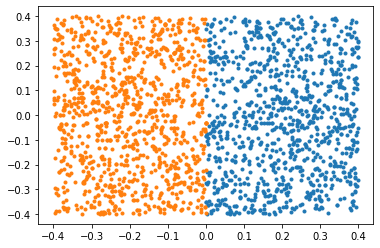

In [34]:
%matplotlib inline 
plt.plot(r1['ra'], r1['dec'], '.')
plt.plot(r2['ra_'], r2['dec'], '.')

In [35]:
from astropy.table import Table
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import Column
from astropy.table import join

r1t = Table.from_pandas(r1)
r2t = Table.from_pandas(r2)


In [93]:
results = vstack([r1t, r2t], join_type='inner')
results['starId'] = np.arange(len(results))
results

ra,dec,phot_g_mean_mag,phot_variable_flag,designation,phot_g_n_obs,dup,starId
float64,float64,float32,str13,str28,int32,int32,int64
0.005974969972104082,0.30453093070747034,16.093906,NOT_AVAILABLE,Gaia DR2 2738214966016683136,363,0,0
0.010248919061348453,0.3092860334869631,19.870337,NOT_AVAILABLE,Gaia DR2 2738215000376421120,344,0,1
0.10056913948187958,0.3099418626418583,21.039972,NOT_AVAILABLE,Gaia DR2 2738203451208751616,104,0,2
0.10282311203123236,0.3001424341210492,20.705063,NOT_AVAILABLE,Gaia DR2 2738202660934644096,205,0,3
0.11794329049845162,0.3058937872048441,20.643808,NOT_AVAILABLE,Gaia DR2 2738202695294548352,218,0,4
0.1373387661048865,0.317136423032938,20.4826,NOT_AVAILABLE,Gaia DR2 2738202764013630208,257,1,5
0.1449606149724322,0.3141570397523224,17.229626,NOT_AVAILABLE,Gaia DR2 2738202768309563392,357,0,6
0.16705341106820396,0.3149841625214468,10.88986,NOT_AVAILABLE,Gaia DR2 2738204039619883136,336,0,7
0.16794169237346368,0.3069555271529232,20.186724,NOT_AVAILABLE,Gaia DR2 2738203966604470400,269,0,8


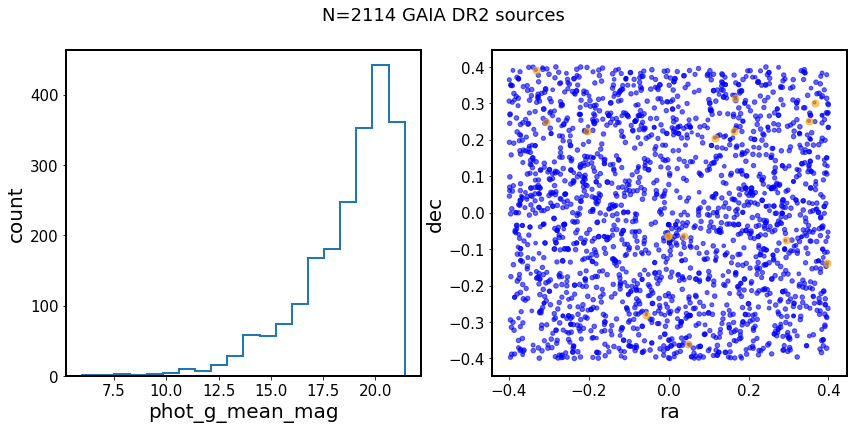

In [91]:
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

fig,ax = plt.subplots(1,2,figsize=(14,6))
fig.suptitle('N=%d GAIA DR2 sources'%len(results))
ax[0].hist(results['phot_g_mean_mag'], histtype='step',lw=2, bins=20)
ax[0].set_xlabel('phot_g_mean_mag')
ax[0].set_ylabel('count')
# I plot here separately r1 and r2 because otherwise 
#inner stacking takes away the ra_  shifted column that 
# is present only in the left part of the query ... 
ax[1].scatter(r1['ra'], r1['dec'],s=r1['phot_g_mean_mag'], c='b', alpha=0.6)
ax[1].scatter(r2['ra_'], r2['dec'], s=r2['phot_g_mean_mag'],c='b',alpha=0.6)

# plot sources that are brighter than 10 - should they be excluded ? 
cutMag = 11
m = r1['phot_g_mean_mag'] < cutMag
ax[1].scatter(r1['ra'][m], r1['dec'][m],s=50, c='orange', alpha=0.6)

m = r2['phot_g_mean_mag'] < cutMag
ax[1].scatter(r2['ra_'][m], r2['dec'][m],s=50, c='orange', alpha=0.6)



ax[1].set_xlabel('ra')
ax[1].set_ylabel('dec')
plt.savefig('GAIA_DR2_ComCam_FOV.png', bbox_inches='tight', dpi=100)

There are built-in limits in https://github.com/lsst-ts/ts_wep/blob/master/python/lsst/ts/wep/bsc/Filter.py  . Te-Wei said "The values initially comes from the SPT-343.We could put those values into a configuration file instead of hard-coded in a latter time." , and he acknowleged that sources outside of these ranges are discarded to decrease the memory use  - apparently according to the 2016-2017 UW study, "for each CCD, we could have >1500 - 2000 stars. The number of sources in this spec will be only < 100 stars."
    
     # Magnitude boundary for each filter type
    U_LOW_MAG = 7.94
    U_HIGH_MAG = 14.80

    G_LOW_MAG = 9.74
    G_HIGH_MAG = 16.17

    R_LOW_MAG = 9.56
    R_HIGH_MAG = 15.73

    I_LOW_MAG = 9.22
    I_HIGH_MAG = 15.26

    Z_LOW_MAG = 8.83
    Z_HIGH_MAG = 14.68

    Y_LOW_MAG = 8.02
    Y_HIGH_MAG = 13.76
    
    

Since we want to see how the realistic field would look like, I'm not going to make any cuts: save in the format 

    # Id	 Ra		 Decl		 Mag
    0	 359.704865	 -0.249369	 16.000000
    1	 359.708385	 -0.249369	 16.000000
    2	 359.704865	 -0.014669	 16.000000
    3	 359.708385	 -0.014669	 16.000000
    4	 359.704865	 0.220031	 16.000000

Use exactly the same writing routine as ts_phosim `exportSkyToFile` : https://github.com/lsst-ts/ts_phosim/blob/master/python/lsst/ts/phosim/SkySim.py 
    
    

In [95]:
# Add the header (star ID, ra, decl, magnitude)
content = "# Id\t Ra\t\t Decl\t\t Mag\n"

results['starId'] = np.arange(len(results))

# Add the star information
for i in range(len(results['starId'])):
    content += "%d\t %3.6f\t %3.6f\t %3.6f\n" % (
        results['starId'][i], results['ra'][i], results['dec'][i], results['phot_g_mean_mag'][i])
path = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/'
fname = 'starCatGAIA.txt'
outputFilePath = path+fname

# Write into file
fid = open(outputFilePath, "w")
fid.write(content)
fid.close()